In [37]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [38]:
jpg_folder_path = 'F:\ARIK\Foto Arik\Datasets_acne'
file_names = os.listdir(jpg_folder_path)
images = []
for file_name in file_names:
    file_path = os.path.join(jpg_folder_path, file_name)
    if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):  # Check if the file is a JPG
        img = Image.open(file_path)
        images.append(img)

In [39]:
images = []
labels = []
label_mapping = {
    'Level_1': 0,
    'Level_2': 1,
    'Level_3': 2,
    'Level_4': 3
}
for subdir in os.listdir(jpg_folder_path):
    subdir_path = os.path.join(jpg_folder_path, subdir)

    if os.path.isdir(subdir_path):
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            
            if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):  
                img = Image.open(file_path)
                images.append(img)
                labels.append(subdir)

In [40]:
print(len(images))
print(len(labels))

1339
1339


In [41]:
resized_images = [img.resize((128, 128)) for img in images]
normalized_images = [np.array(img) / 255.0 for img in resized_images]
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

augmented_images = []
for img in normalized_images:
    img = np.expand_dims(img, axis=0) 
    augmented_img = datagen.flow(img, batch_size=1)[0][0]
    augmented_images.append(augmented_img)

In [42]:
train_folder = 'F:\ARIK\Foto Arik\Dataset_acne_train'
test_folder = 'F:\ARIK\Foto Arik\Dataset_acne_test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for subfolder in os.listdir(jpg_folder_path):
    subfolder_path = os.path.join(jpg_folder_path, subfolder)
    train_subfolder_path = os.path.join(train_folder, subfolder)
    test_subfolder_path = os.path.join(test_folder, subfolder)

    if subfolder != ".DS_Store": 
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)

        image_files = [file for file in os.listdir(subfolder_path) if file.endswith('.jpg') or file.endswith('.jpeg')]

        random.shuffle(image_files)

        split_index = int(0.8 * len(image_files))
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]

        for train_file in train_files:
            src_path = os.path.join(subfolder_path, train_file)
            dst_path = os.path.join(train_subfolder_path, train_file)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

        for test_file in test_files:
            src_path = os.path.join(subfolder_path, test_file)
            dst_path = os.path.join(test_subfolder_path, test_file)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

print("Training folder:", train_folder)
print("Testing folder:", test_folder)


Training folder: F:\ARIK\Foto Arik\Dataset_acne_train
Testing folder: F:\ARIK\Foto Arik\Dataset_acne_test


In [43]:
dataset_folder = jpg_folder_path 
image_size = (128, 128) 
batch_size = 45
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = image_dataset.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)


Found 1339 files belonging to 4 classes.
Class names: ['Level_1', 'Level_2', 'Level_3', 'Level_4']
Number of classes: 4


## MODEL

In [44]:
input_t = tf.keras.Input(shape=(128,128,3))
resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)


In [45]:
def build_model(base_model, num_classes):

  for layer in base_model.layers:
    layer.trainable = False

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (128,128))))
  model.add(base_model)
  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(1024,activation=('relu')))
  model.add(tf.keras.layers.Dense(512,activation=('relu')))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(256,activation=('relu'))) 
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(128,activation=('relu')))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

  return model

class_list = os.listdir(jpg_folder_path)
model = build_model(resnet_model, num_classes = len(class_list))
check_point = tf.keras.callbacks.ModelCheckpoint("dermnet.h5", 
                                                 monitor='val_accuracy', 
                                                 verbose=1, 
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')
     

In [46]:

TRAINING_DIR = 'F:\ARIK\Foto Arik\Dataset_acne_train'
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = 'F:\ARIK\Foto Arik\Dataset_acne_test'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=45
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=45
)


Found 1069 images belonging to 4 classes.
Found 270 images belonging to 4 classes.


In [47]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = validation_generator.n // validation_generator.batch_size
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[tf.keras.callbacks.CSVLogger('training.log')]
)
train_accuracy = history.history['accuracy']
print("Training Accuracy:", train_accuracy[-1])

Epoch 1/100
23/23 [==============================] - 76s 3s/step - loss: 1.5678 - accuracy: 0.3086 - val_loss: 1.3221 - val_accuracy: 0.3519
Epoch 2/100
23/23 [==============================] - 63s 3s/step - loss: 1.3540 - accuracy: 0.3193 - val_loss: 1.3356 - val_accuracy: 0.2889
Epoch 3/100
23/23 [==============================] - 61s 3s/step - loss: 1.3404 - accuracy: 0.3037 - val_loss: 1.3084 - val_accuracy: 0.3519
Epoch 4/100
23/23 [==============================] - 61s 3s/step - loss: 1.3374 - accuracy: 0.3066 - val_loss: 1.3081 - val_accuracy: 0.3519
Epoch 5/100
23/23 [==============================] - 61s 3s/step - loss: 1.3186 - accuracy: 0.3438 - val_loss: 1.3144 - val_accuracy: 0.3519
Epoch 6/100
23/23 [==============================] - 62s 3s/step - loss: 1.3131 - accuracy: 0.3184 - val_loss: 1.2850 - val_accuracy: 0.3519
Epoch 7/100
23/23 [==============================] - 63s 3s/step - loss: 1.2899 - accuracy: 0.3467 - val_loss: 1.2410 - val_accuracy: 0.3519
Epoch 8/100
2

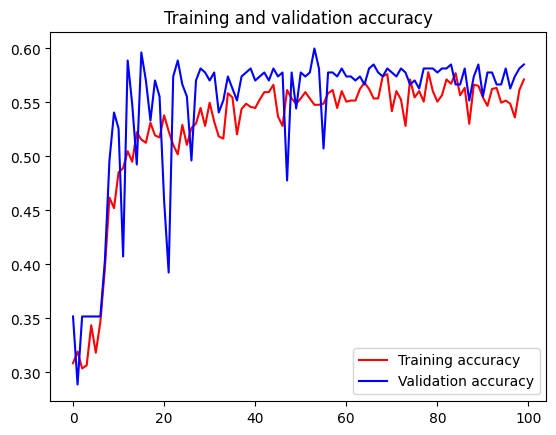

<Figure size 640x480 with 0 Axes>

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [49]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

loss, accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", accuracy)


Found 270 files belonging to 4 classes.
6/6 [==============================] - 10s 1s/step - loss: 22.2419 - accuracy: 0.2889
Test Accuracy: 0.2888889014720917


In [55]:
image_path = '"F:\ARIK\Foto Arik\Dataset_acne_test\Level_1\level1_(12).jpg"'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128, 3))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
prediction = model.predict(image)
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)


OSError: [Errno 22] Invalid argument: '"F:\\ARIK\\Foto Arik\\Dataset_acne_test\\Level_1\\level1_(12).jpg"'